In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

# setting things up:

In [2]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"
output_path = path / "Output"
paths = forcing_path, output_path, observations_path
figure_path = path / "Figures"

In [3]:
units= {"Imax":"mm",
        "Ce": "-",
        "Sumax": "mm",
        "Beta": "-",
        "Pmax": "mm",
        "Tlag": "d",
        "Kf": "-",
        "Ks": "-",
        "FM":'mm/d/degC',
        "Si": "mm",
        "Su": "mm",
        "Sf": "mm",
        "Ss": "mm",
        "Sp": "mm",
        "Ei_dt": "mm/d",
        "Ea_dt": "mm/d",
        "Qs_dt": "mm/d",
        "Qf_dt": "mm/d",
        "Q_tot_dt": "mm/d",
        "Q": "mm/d"}

p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
names = p_names + S_names
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

var_names =  {x: names[i] for i, x in enumerate(param_names + stor_names)}

In [4]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qm - Qo)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)
    
def calc_log_NSE(Qo, Qm):
    Qo[Qo == 0] = 1e-6
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((np.log(Qm) - np.log(Qo))**2)
    ErrDo = np.sum((np.log(Qo) - np.log(QoAv))**2)
    return 1 - (ErrUp / ErrDo)

In [5]:
def plot_hydrograph(ds_combined, ax):
    NSE_mean = calc_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    NSE_mean_log = calc_log_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    
    ds_combined["Q_obs"].plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')
    
    ds_combined["Q"].sel(summary_stat="mean").plot(ax=ax, color="C1",lw=0.5,label=f"mean NSE: {NSE_mean:.2f}\n   Log NSE: {NSE_mean_log:.2f}",zorder=-1)
    
    ax.fill_between(ds_combined.time, 
                             ds_combined["Q"].sel(summary_stat="min").values,
                             ds_combined["Q"].sel(summary_stat="max").values,color="C0", alpha=0.35,zorder=-10,label="bounds")
    n_particles = ds_combined.attrs['n_particles']
    ax.set_ylabel("Q [mm]")
    ax.set_title(f"Run ensemble of {n_particles} particles");
    return ax

In [6]:
def plot_variable(ds_combined, variable, axs):    
    axs[0] = plot_hydrograph(ds_combined, axs[0])
    n_particles = ds_combined.attrs['n_particles']
    
    for i, var in enumerate(variable):
        for j in range(n_particles):
            axs[i+1].fill_between(ds_combined.time, 
                             ds_combined[var].sel(summary_stat="min").values,
                             ds_combined[var].sel(summary_stat="max").values, color=f"C{i}",alpha=0.5)
            axs[i+1].set_title(var_names[var])
            axs[i+1].set_ylabel(f'{var} [{units[var]}]')
    return axs

# Loading files

In [20]:
# files = list((output_path / "n_200_3y").glob('*.nc'))
# files = list((output_path / "n_400_5y").glob('*.nc'))
files = list((output_path).glob('*N-400*.nc'))

In [21]:
HRU_ids = list(set([file.name.split('_')[0] for file in files]))

In [22]:
dict_files = {}
[dict_files.update(
                   {f"{file.name.split('_')[0]}_{float(file.name.split('_')[1].split('-')[1])}" : file}
                    ) for file in files]
sorted_iter = sorted(dict_files.keys())[::-1]

In [23]:
len(set([file.name.split("_")[0] for file in files]).intersection(set(HRU_ids)))

1

In [24]:
sorted_iter

['01181000_0.5',
 '01181000_0.4',
 '01181000_0.3',
 '01181000_0.2',
 '01181000_0.1',
 '01181000_0.01']

In [25]:
lst_ds = []
for key in sorted_iter:
    ds = xr.open_dataset(dict_files[key])
    lst_ds.append(ds)

In [26]:
i = 3
ds_combined = lst_ds[i]
ds_combined

<xarray.Dataset>
Dimensions:       (summary_stat: 3, time: 3683)
Coordinates:
  * summary_stat  (summary_stat) <U4 'min' 'max' 'mean'
  * time          (time) datetime64[ns] 1997-08-01 1997-08-02 ... 2007-08-31
Data variables: (12/18)
    Imax          (summary_stat, time) float64 ...
    Ce            (summary_stat, time) float64 ...
    Sumax         (summary_stat, time) float64 ...
    Beta          (summary_stat, time) float64 ...
    Pmax          (summary_stat, time) float64 ...
    Tlag          (summary_stat, time) float64 ...
    ...            ...
    Ss            (summary_stat, time) float64 ...
    Sp            (summary_stat, time) float64 ...
    Q             (summary_stat, time) float64 ...
    Q_obs         (time) float64 ...
    Neff          (time) float64 ...
    n_resample    (time) float64 ...
Attributes:
    title:              HBV storage & parameter terms data over time for 400 ...
    history:            Storage term results from ewatercycle_HBV.model
    sigma_pp:           0.003
    sigma_ps:           2
    sigma_w:            0.45
    sigma_p_Sf:         0.2
    assimilate_window:  3
    n_particles:        400
    HRU_id:             01181000

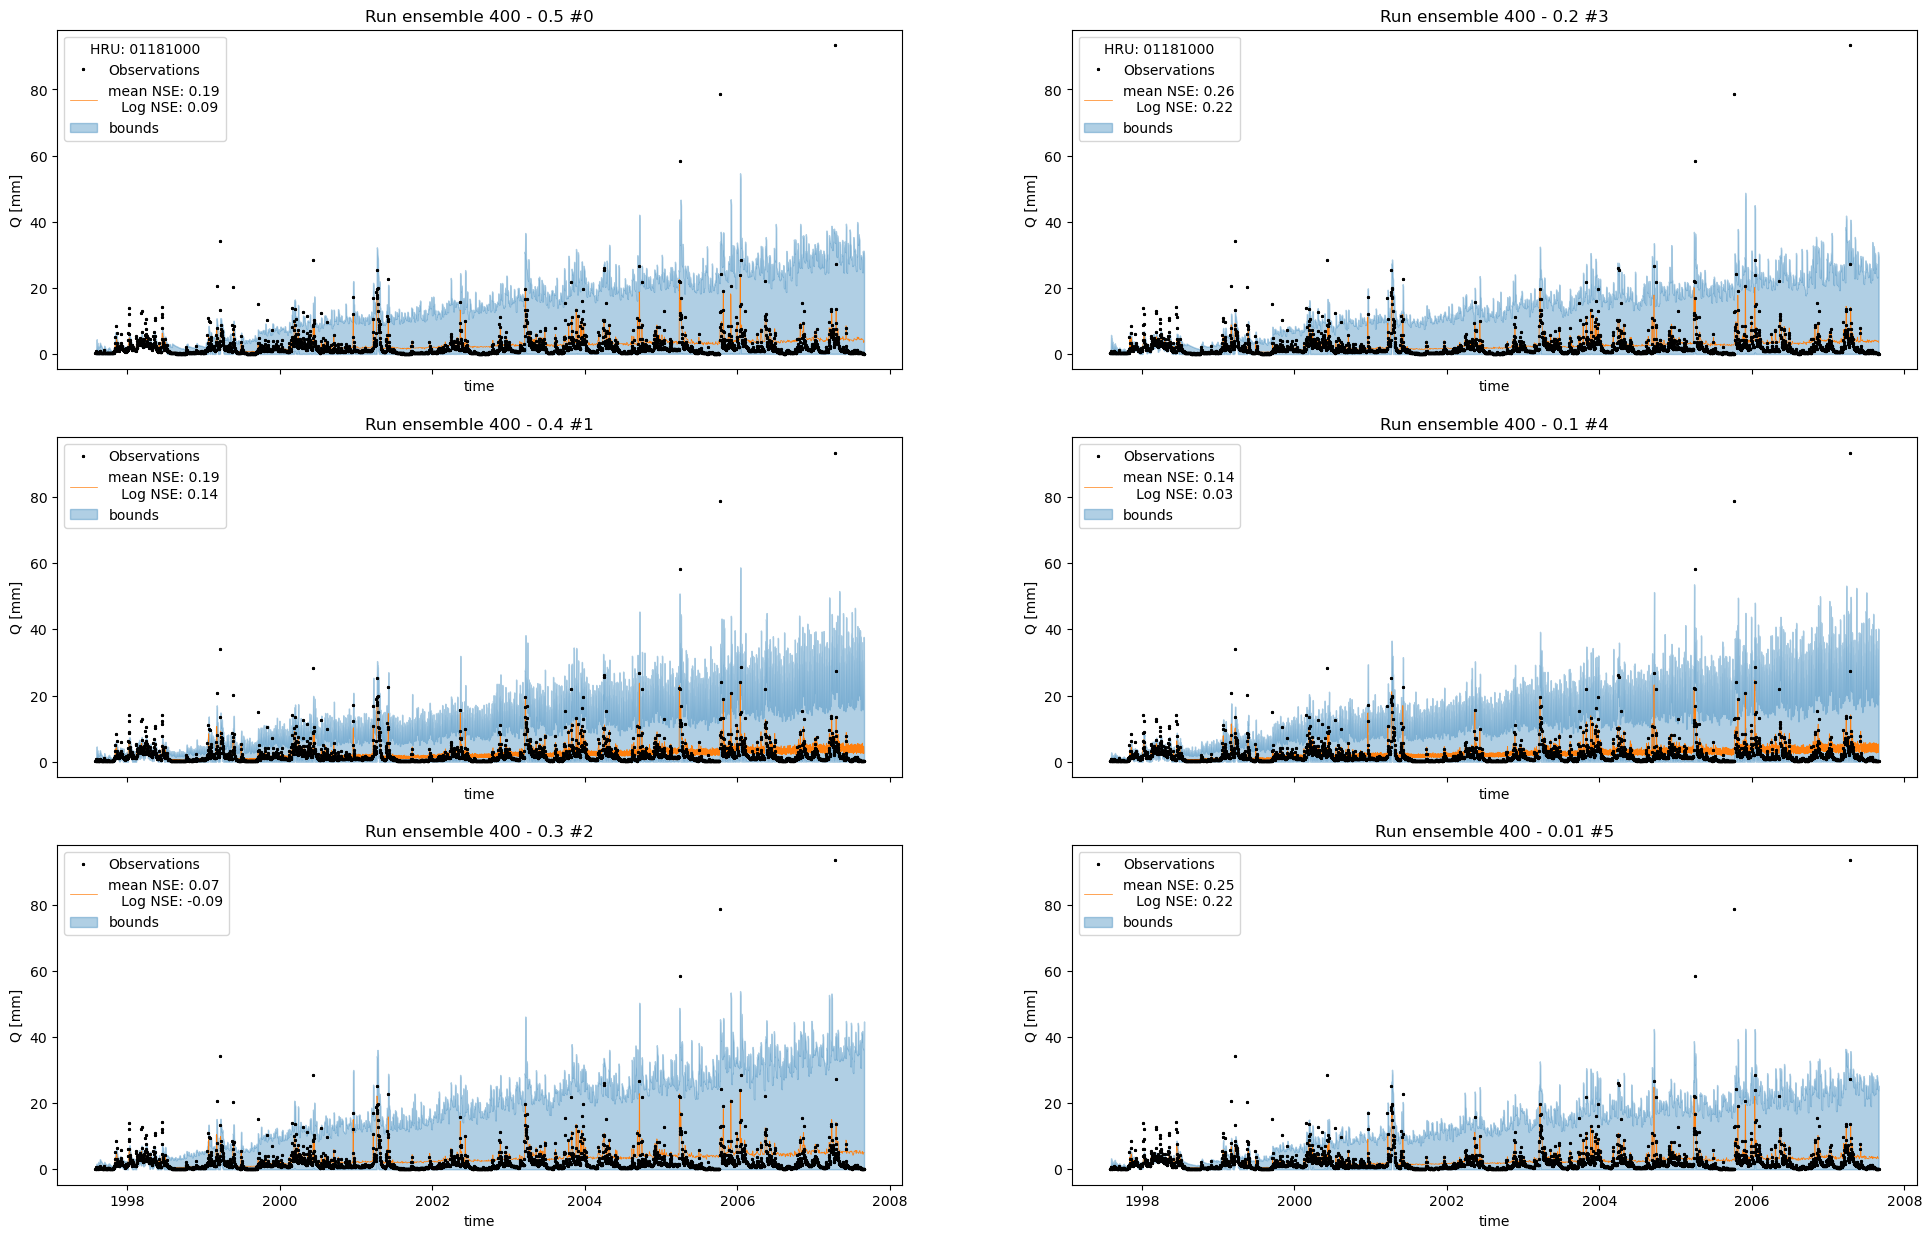

In [28]:
y1, x1   = 3, 2
fig, axs_2d = plt.subplots(y1,x1,figsize=(12*x1,5*y1), sharex=True)
j = 0
k = 0
for i in range(0,x1*y1):
    if k >= y1: 
        j += 1
        k = 0
    ax = axs_2d[k, j]
    k += 1
    
    ds_combined = lst_ds[i]
    ax = plot_hydrograph(ds_combined, ax)
    ax.set_title(f'Run ensemble {ds_combined.attrs["n_particles"]} - {ds_combined.attrs["sigma_p_Sf"]} #{i}')
    if k == 1:
        ax.legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
    else:
        ax.legend()

# fig.savefig(figure_path / f'itterate_sigma_p_sf_first-{x1}_catchments.png', bbox_inches="tight",dpi=400)

In [29]:
files = list((output_path).glob('*N-700*.nc'))
dict_files = {}
[dict_files.update(
                   {f"{file.name.split('_')[0]}_{float(file.name.split('_')[1].split('-')[1])}" : file}
                    ) for file in files]
sorted_iter = sorted(dict_files.keys())[::-1]
sorted_iter


['01181000_0.5',
 '01181000_0.4',
 '01181000_0.3',
 '01181000_0.2',
 '01181000_0.1',
 '01181000_0.01']

In [32]:
[file.name for file in files]

['01181000_psf-0.4_pp-0.003_ps-2_w-0.45_N-700_2024-05-08 12_00.nc',
 '01181000_psf-0.2_pp-0.003_ps-2_w-0.45_N-700_2024-05-08 13_22.nc',
 '01181000_psf-0.3_pp-0.003_ps-2_w-0.45_N-700_2024-05-08 13_03.nc',
 '01181000_psf-0.5_pp-0.003_ps-2_w-0.45_N-700_2024-05-08 11_42.nc',
 '01181000_psf-0.1_pp-0.003_ps-2_w-0.45_N-700_2024-05-08 13_40.nc',
 '01181000_psf-0.01_pp-0.003_ps-2_w-0.45_N-700_2024-05-08 13_59.nc']

In [30]:
lst_ds = []
for key in sorted_iter:
    ds = xr.open_dataset(dict_files[key])
    lst_ds.append(ds)

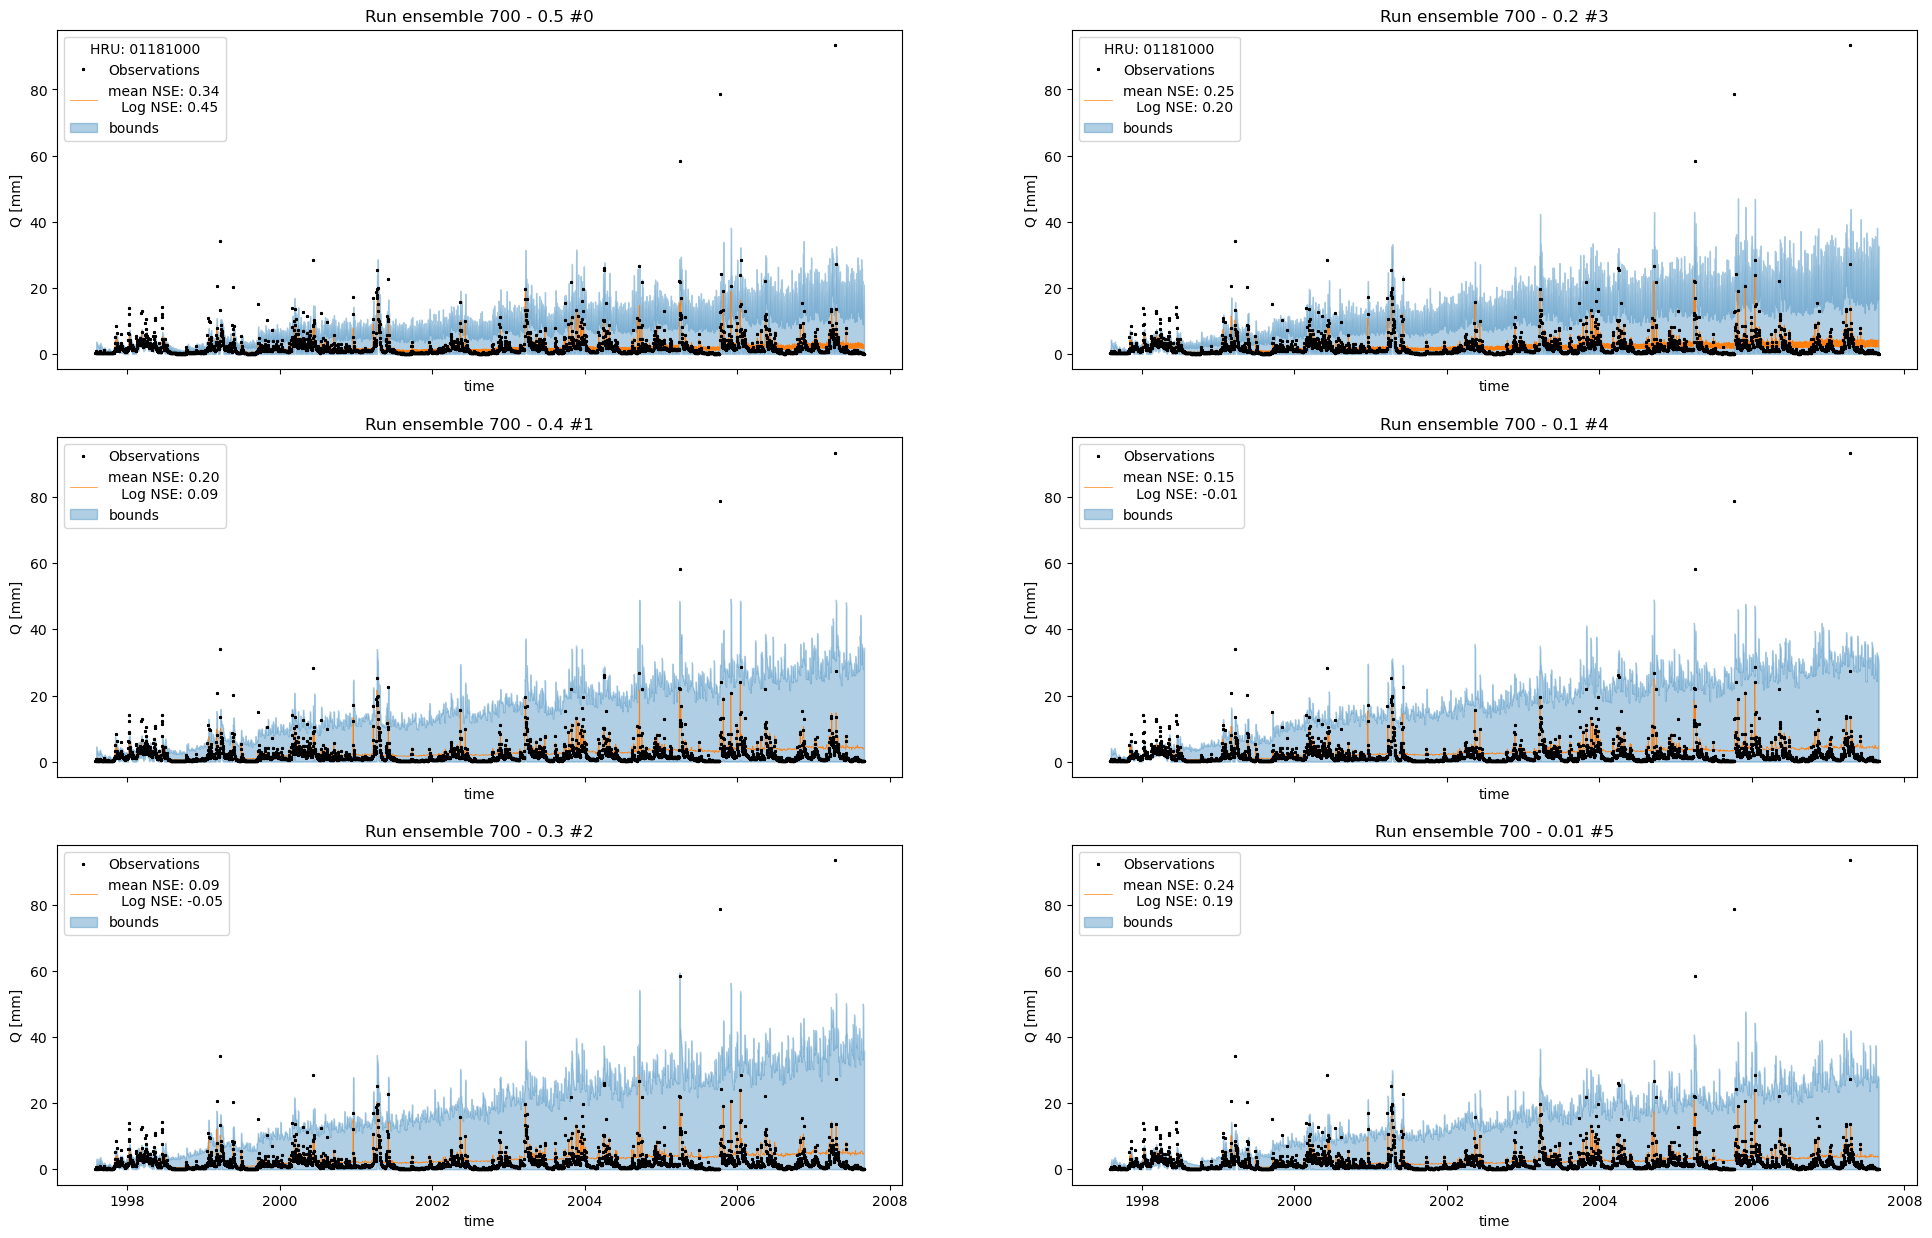

In [31]:
y1, x1   = 3, 2
fig, axs_2d = plt.subplots(y1,x1,figsize=(12*x1,5*y1), sharex=True)
j = 0
k = 0
for i in range(0,x1*y1):
    if k >= y1: 
        j += 1
        k = 0
    ax = axs_2d[k, j]
    k += 1
    
    ds_combined = lst_ds[i]
    ax = plot_hydrograph(ds_combined, ax)
    ax.set_title(f'Run ensemble {ds_combined.attrs["n_particles"]} - {ds_combined.attrs["sigma_p_Sf"]} #{i}')
    if k == 1:
        ax.legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
    else:
        ax.legend()

# fig.savefig(figure_path / f'itterate_sigma_p_sf_first-{x1}_catchments.png', bbox_inches="tight",dpi=400)